In [1]:
suppressMessages(library(Seurat))
suppressMessages(library(patchwork))
suppressMessages(library(Matrix))
suppressMessages(library(data.table))
suppressMessages(library(tidyverse))
suppressMessages(library(monocle))
suppressMessages(library(conflicted))
suppressMessages(library(cowplot))

Warning message:
“package ‘Seurat’ was built under R version 4.3.3”
Warning message:
“package ‘SeuratObject’ was built under R version 4.3.3”
Warning message:
“package ‘sp’ was built under R version 4.3.3”
Warning message:
“package ‘patchwork’ was built under R version 4.3.2”
Warning message:
“package ‘Matrix’ was built under R version 4.3.2”
Warning message:
“package ‘data.table’ was built under R version 4.3.3”
Warning message:
“package ‘ggplot2’ was built under R version 4.3.3”
Warning message:
“package ‘tidyr’ was built under R version 4.3.2”
Warning message:
“package ‘readr’ was built under R version 4.3.2”
Warning message:
“package ‘dplyr’ was built under R version 4.3.2”
Warning message:
“package ‘stringr’ was built under R version 4.3.2”
Warning message:
“package ‘monocle’ was built under R version 4.3.3”
Warning message:
“package ‘Biobase’ was built under R version 4.3.3”
Warning message:
“package ‘BiocGenerics’ was built under R version 4.3.2”
Warning message:
“package ‘VGAM’

In [2]:
suppressMessages(conflicts_prefer(Biobase::exprs))
suppressMessages(conflicts_prefer(Biobase::`exprs<-`))
suppressMessages(conflicts_prefer(Biobase::pData))
suppressMessages(conflicts_prefer(Biobase::`pData<-`))
suppressMessages(conflicts_prefer(Biobase::fData))
suppressMessages(conflicts_prefer(Biobase::`fData<-`))
suppressMessages(conflicts_prefer(dplyr::filter))

# Load data

In [3]:
cds_olg_gene_exon = readRDS(file = "/ru-auth/local/home/aliao/scratch/projects/EnrichSci/250112_Enrich_OLG/submission_files/cds_olg_gene_exon.rds")

# DE analysis

In [4]:
cds_gene_exon_mol56 = cds_olg_gene_exon[,cds_olg_gene_exon$OL_subtype == 'MOL_5_6']
cds_gene_exon_mol2 = cds_olg_gene_exon[,cds_olg_gene_exon$OL_subtype == 'MOL_2']

In [5]:
find_DE_cluster_batch_regressed_out <- function (cds, DE_conditions, core_number, 
                                                 reduced_Model_Formula_Str = "~ Gene_count") 
{
    cds = estimateSizeFactors(cds)
    cell_type = as.character(DE_conditions)
    cat("\nCalculate the top expressed cluster of each gene...")
    cds_class_tpm <- class_tpm(cds, cell_type)
    class_label = colnames(cds_class_tpm)
    pData(cds)$tmp = factor(cell_type)
    top_2_cell_type <- do.call(rbind, apply(cds_class_tpm, 1, 
        function(x) {
            a = order(x, decreasing = T)
            b = x[a]
            return(list(max.tissue = class_label[a[1]], second.tissue = class_label[a[2]], 
                max.expr = unname(b[1]), second.expr = unname(b[2]), 
                fold.change = (unname(b[1]) + 0.01)/(unname(b[2]) + 
                  0.01)))
        }))
    top2 <- as.data.frame(top_2_cell_type) %>% mutate(class = max.tissue)
    top2$gene_id = rownames(top_2_cell_type)
    top2$class = as.character(top2$class)
    top2$gene_id = as.character(top2$gene_id)
    cat("\nStart DE analysis for each cluster")
    if (!("num_genes_expressed" %in% names(pData(cds)))) {
        cat("\nData does not have num_genes_expressed column, add detected gene number per cell column...\n")
        cds$num_genes_expressed = Matrix::colSums(exprs(cds) > 
            0)
    }
    
    full_Model_Formula_Str = paste(reduced_Model_Formula_Str, "+ tmp", sep = "")
    DE.genes = differentialGeneTest(cds, fullModelFormulaStr = full_Model_Formula_Str,
        reducedModelFormulaStr = reduced_Model_Formula_Str, cores = core_number)
    DE.genes$gene_id = as.character(DE.genes$gene_id)
    DE.genes$gene_short_name = as.character(DE.genes$gene_short_name)
    cat("\n combine the DE genes and top tissues")
    rownames(top2) = top2$gene_id
    top2 = top2 %>% select(-gene_id)
    result = cbind(DE.genes, top2[rownames(DE.genes), ])
    result$qval = (as.numeric(as.character(result$qval)))
    result_2 = lapply(1:length(result), function(x) {
        unlist(result[[x]])
    })
    result_2 = as.data.frame(result_2)
    colnames(result_2) = names(result)
    return(result_2)
}

In [ ]:
# takes a while to run
df_de_mol56 = find_DE_cluster_batch_regressed_out(cds = cds_gene_exon_mol56, DE_conditions = as.character(cds_gene_exon_mol56$age), 
                                               core_number = 10, reduced_Model_Formula_Str = "~ Gene_count")

In [ ]:
# takes a while to run
df_de_mol2 = find_DE_cluster_batch_regressed_out(cds = cds_gene_exon_mol2, DE_conditions = as.character(cds_gene_exon_mol2$age), 
                                               core_number = 10, reduced_Model_Formula_Str = "~ Gene_count")

# Aging OLG DEGs and DE exons #2 (use jun cutoffs)

## MOL2

In [6]:
df_de_mol2 = read_csv("/ru-auth/local/home/aliao/scratch/projects/EnrichSci/250112_Enrich_OLG/submission_files/DE_df_MOL2.csv")
## ordered by qval and added columns FoldChange and log2FoldChange, comparing expression in '25mo' vs '2mo'

New names:
• `` -> `...1`
• `...3` -> `...2`
Rows: 254353 Columns: 25
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (11): ...2, status, family, gene_id, gene_type, gene_short_name, exon_id...
dbl (14): ...1, pval, qval, n_cells_by_counts, mean_counts, log1p_mean_count...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [ ]:
# DE genes

In [7]:
df_de_gene = df_de_mol2
df_de_gene = df_de_gene %>% filter(gene_or_exon == "gene", qval < 0.05, fold.change > 1.5, max.expr > 25)
table(df_de_gene$class)

DEG_2 = df_de_gene
dim(DEG_2)


25mo  2mo 
 147  104 

[1] 251  25

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


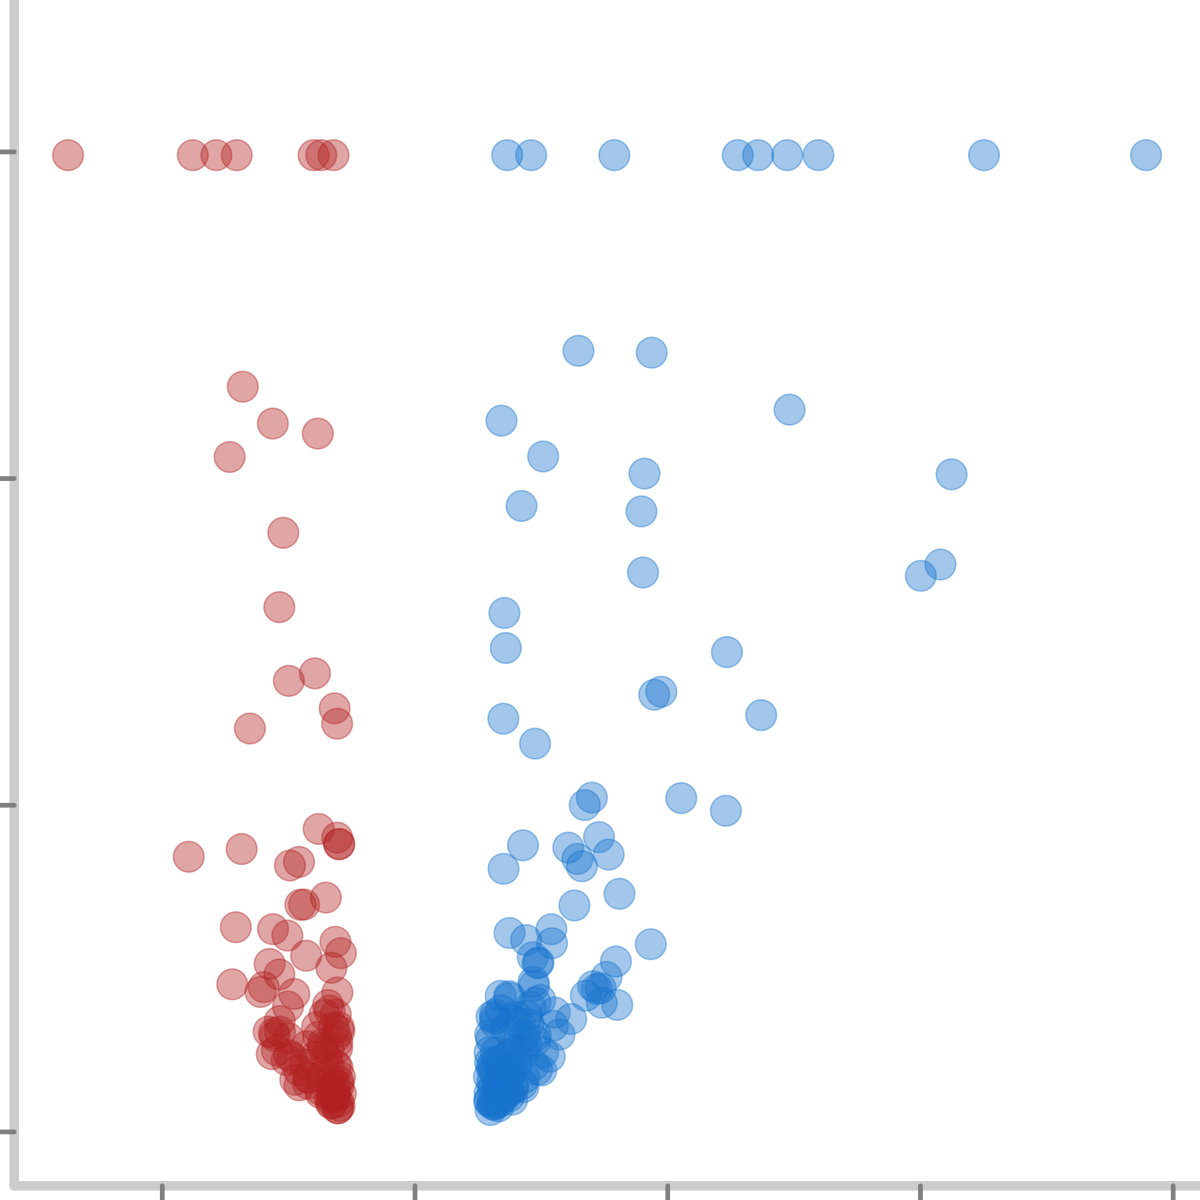

In [8]:
options(repr.plot.width = 10, repr.plot.height = 10)
DEG_2$color_group <- ifelse(DEG_2$class == '25mo', "up", "down")

ggplot(DEG_2, aes(x = log2FoldChange, y = -log10(qval), color = significance)) +
  geom_point(data = DEG_2, aes(color = color_group), alpha = 0.4, size = 8) +  
    scale_color_manual(values = c("up" = "dodgerblue3", "down" = "firebrick")) +
    scale_x_continuous(limits = c(min(DEG_2$log2FoldChange), max(DEG_2$log2FoldChange))) + 
    scale_y_continuous(limits = c(0, 330)) +  
  labs(
    x = "log2 Fold Change",
    y = "-log10(q-value)"
  ) +

  theme_void() +
  theme(
     legend.position = 'none',
  axis.line.x = element_line(color = "gray80", size = 2),
  axis.line.y = element_line(color = "gray80", size = 2),

  axis.text.x = element_blank(),   
  axis.text.y = element_blank(),      
  axis.ticks.length = unit(0.3, "cm"),
  axis.ticks = element_line(color = "gray50", size = 1), 
  axis.title.x = element_blank(),  
  axis.title.y = element_blank()
  )


In [ ]:
# DE exons

In [9]:
df_de_exon = df_de_mol2
df_de_exon = df_de_exon %>% filter(gene_or_exon != "gene", qval < 0.05, fold.change > 1.5, max.expr > 10)
table(df_de_exon$class)

df_dee_mol2 = df_de_exon
dim(df_dee_mol2)


25mo  2mo 
  61  200 

[1] 261  25

In [10]:
df_dee_mol2$significance = 'DE exon'
df_gene_mol2 = df_de_mol2[df_de_mol2$gene_or_exon == 'gene',]
df_gene_mol2$significance = ifelse(df_gene_mol2$qval < 0.05 & df_gene_mol2$fold.change > 1.5 & df_gene_mol2$max.expr > 10, 'DE gene', 'Non-DE gene')

In [11]:
table(df_gene_mol2$significance) #filtered using same cutoffs as DE exons


    DE gene Non-DE gene 
        544       25833 

In [12]:
df_dee_mol2 <- df_dee_mol2 %>%
  filter(significance == "DE exon") %>%
  select(gene_short_name, log2FoldChange, significance, exon_id, qval)

DE_genes2 <- df_gene_mol2 %>%
  filter(gene_or_exon == "gene") %>%
  mutate(DE_status = ifelse(significance == "DE gene", "DE gene", "Non-DE gene")) %>%
  select(gene_short_name, log2FoldChange, qval, DE_status)
DE_genes2 <- DE_genes2 %>%
  arrange(gene_short_name, qval) %>%  
  distinct(gene_short_name, .keep_all = TRUE) 

# get the corresponding gene log2FoldChange values for each DE exon
DE_exons_MOL2 <- df_dee_mol2 %>%
  left_join(DE_genes2 %>% select(gene_short_name, log2FoldChange, DE_status), 
            by = "gene_short_name", suffix = c("_exon", "_gene")) %>%
  mutate(DE_status = ifelse(is.na(DE_status), "Non-DE gene", DE_status))

In [13]:
table(DE_exons_MOL2$DE_status)


    DE gene Non-DE gene 
        150         111 

Warning message:
“package ‘ggrepel’ was built under R version 4.3.2”
Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


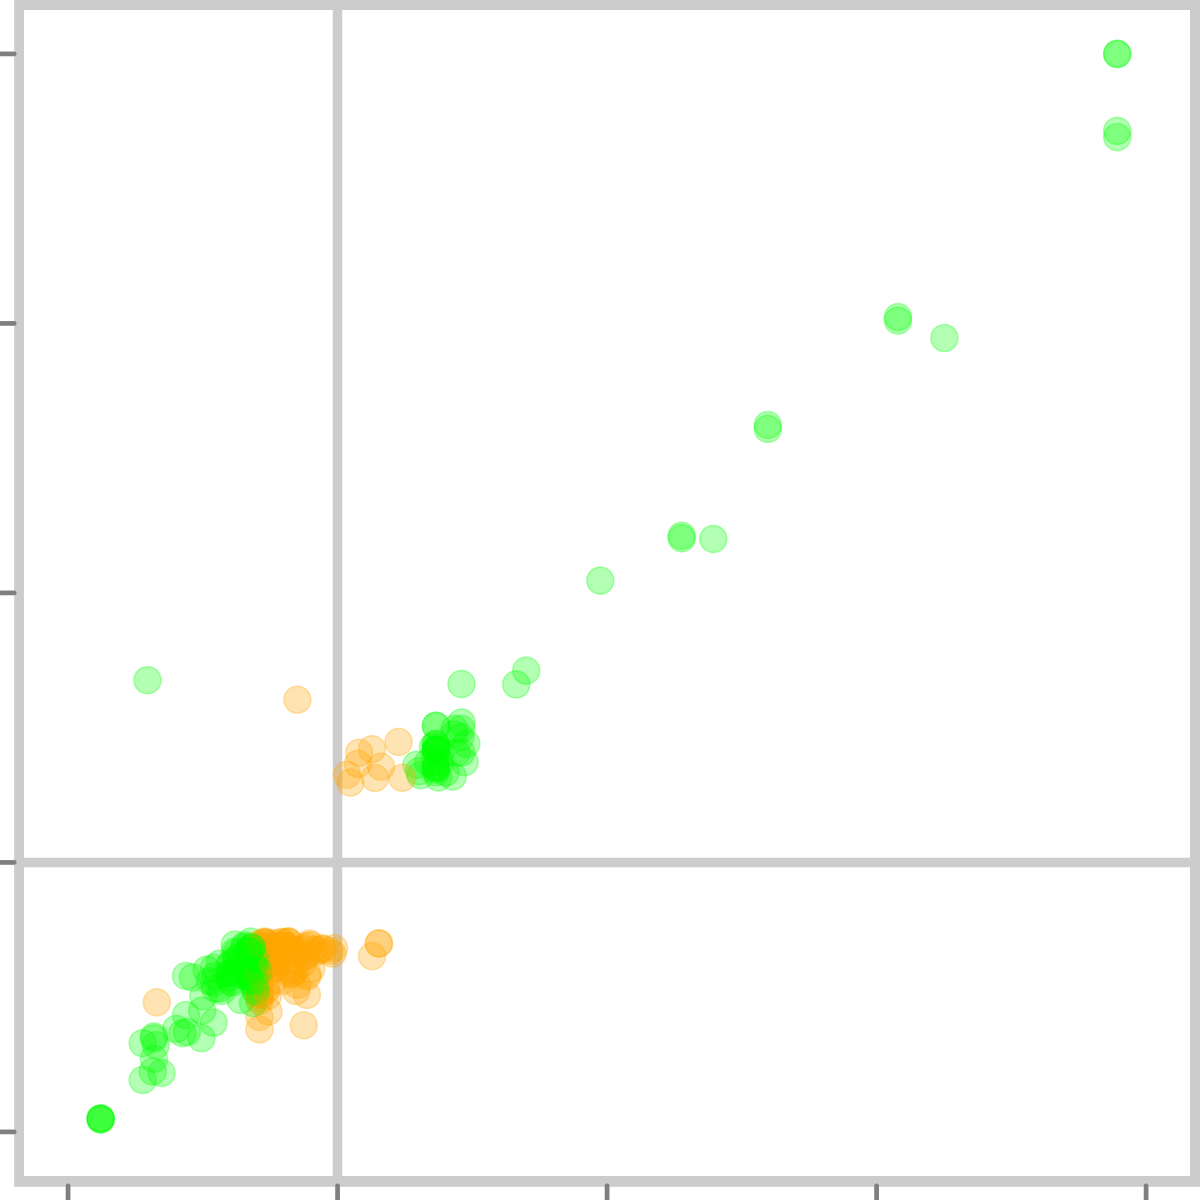

In [14]:
options(repr.plot.width = 10, repr.plot.height = 10)
library(ggrepel)

# Cap values for better visualization
DE_exons_with_gene_fc_capped <- DE_exons_MOL2 %>%
  mutate(
    log2FoldChange_exon = pmin(pmax(log2FoldChange_exon, -6), 6),
    log2FoldChange_gene = pmin(pmax(log2FoldChange_gene, -6), 6)
  )

ggplot(DE_exons_with_gene_fc_capped, aes(x = log2FoldChange_gene, y = log2FoldChange_exon, color = DE_status)) +
  geom_hline(yintercept = 0, color = "gray80", size = 2) +
  geom_vline(xintercept = 0, color = "gray80", size = 2) +
  
  geom_point(alpha = 0.3, size = 7) +  

  scale_color_manual(values = c("DE gene" = "green", "Non-DE gene" = "orange1")) +
  
  scale_x_continuous(limits = c(-2, 6), breaks = seq(-6, 6, by = 2),
                     labels = function(x) ifelse(x == -6, "≤-6", ifelse(x == 6, "≥6", x))) +
  scale_y_continuous(limits = c(-2, 6), breaks = seq(-6, 6, by = 2),
                     labels = function(y) ifelse(y == -6, "≤-6", ifelse(y == 6, "≥6", y))) +

  theme_void() +
  labs(
    x = "Gene log2FoldChange",
    y = "Exon log2FoldChange",
    color = "Gene Type"
  ) +

  theme(
    panel.border = element_rect(color = "gray80", fill = NA, size = 4),  
      axis.text.x = element_blank(),      
  axis.text.y = element_blank(),     
  axis.ticks.length = unit(0.3, "cm"), 
  axis.ticks = element_line(color = "gray50", size = 1), 
    legend.position = "none" 
  )



In [15]:
table(DE_exons_with_gene_fc_capped$DE_status)


    DE gene Non-DE gene 
        150         111 

## MOL5/6

In [16]:
df_de_mol56 = read_csv("/ru-auth/local/home/aliao/scratch/projects/EnrichSci/250112_Enrich_OLG/submission_files/DE_df_MOL56.csv")
## ordered by qval and added columns FoldChange and log2FoldChange, comparing expression in '25mo' vs '2mo'

New names:
• `` -> `...1`
Rows: 254353 Columns: 25
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (11): ...2, status, family, gene_id, gene_type, gene_short_name, exon_id...
dbl (14): ...1, pval, qval, n_cells_by_counts, mean_counts, log1p_mean_count...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [ ]:
# DE genes

In [17]:
df_de_gene = df_de_mol56
df_de_gene = df_de_gene %>% filter(gene_or_exon == "gene", qval < 0.05, fold.change > 1.5, max.expr > 25)
table(df_de_gene$class)

DEG_5 = df_de_gene
dim(DEG_5)


25mo  2mo 
 202   92 

[1] 294  25

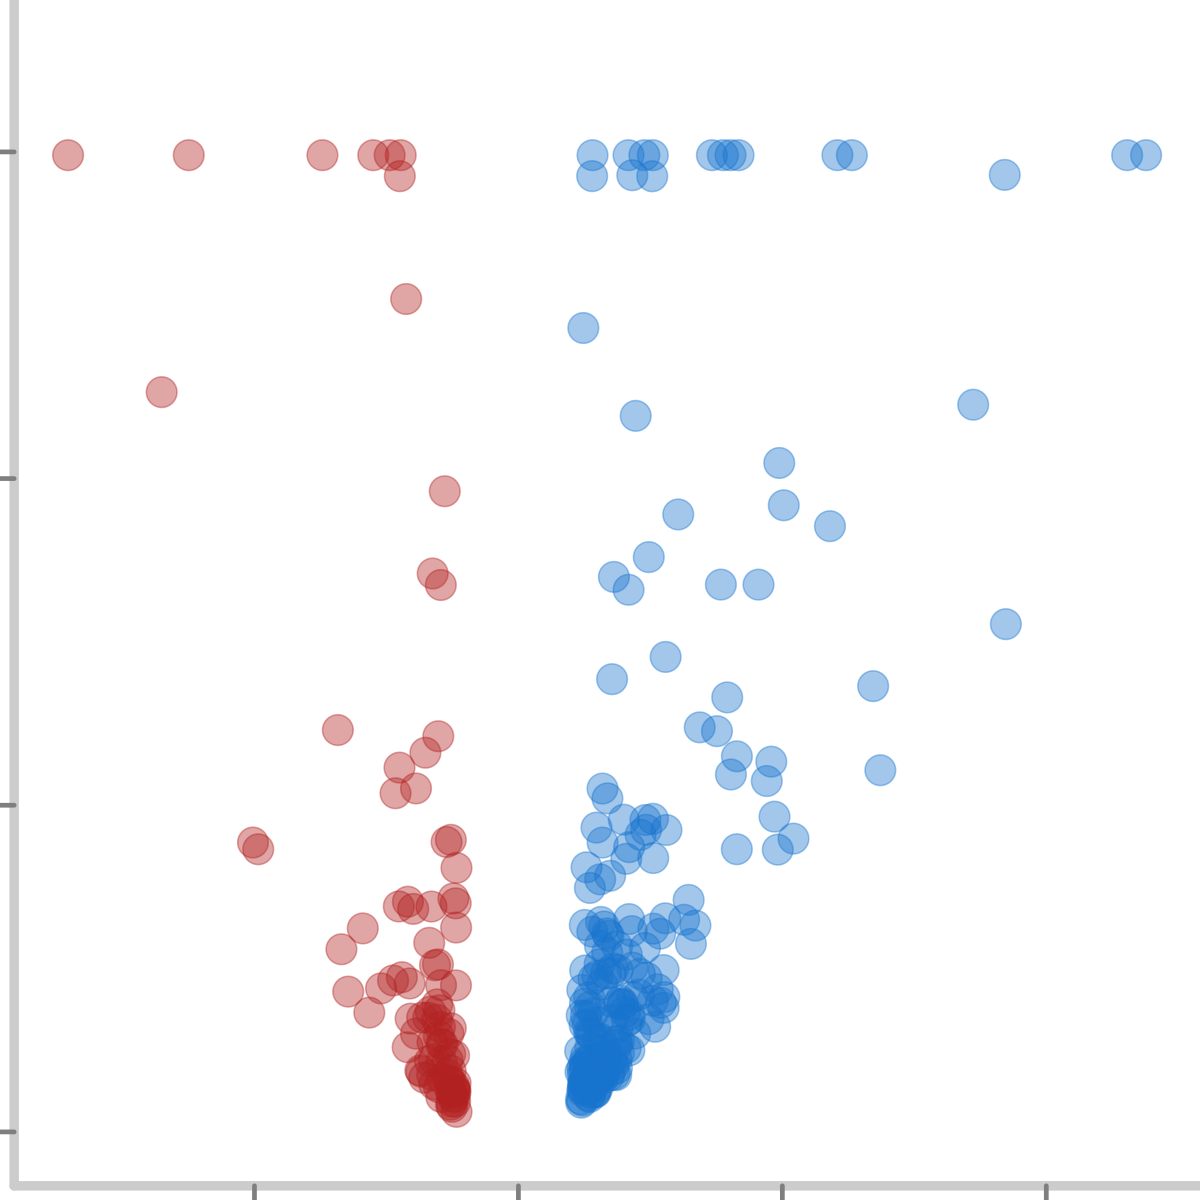

In [18]:
options(repr.plot.width = 10, repr.plot.height = 10)
DEG_5$color_group <- ifelse(DEG_5$class == '25mo', "up", "down")

ggplot(DEG_5, aes(x = log2FoldChange, y = -log10(qval), color = significance)) +
  geom_point(data = DEG_5, aes(color = color_group), alpha = 0.4, size = 8) +  
    scale_color_manual(values = c("up" = "dodgerblue3", "down" = "firebrick")) +
  scale_x_continuous(limits = c(min(DEG_5$log2FoldChange), max(DEG_5$log2FoldChange))) +  
  scale_y_continuous(limits = c(0, 330)) +  
  labs(
    x = "log2 Fold Change",
    y = "-log10(q-value)"
  ) +
  theme_void() +
  theme(
     legend.position = 'none',
  axis.line.x = element_line(color = "gray80", size = 2),
  axis.line.y = element_line(color = "gray80", size = 2),
  axis.text.x = element_blank(),      
  axis.text.y = element_blank(),      
  axis.ticks.length = unit(0.3, "cm"), 
  axis.ticks = element_line(color = "gray50", size = 1), 
  axis.title.x = element_blank(),  
  axis.title.y = element_blank()
  )

In [ ]:
# DE exons

In [19]:
df_de_exon = df_de_mol56
df_de_exon = df_de_exon %>% filter(gene_or_exon != "gene", qval < 0.05, fold.change > 1.5, max.expr > 10)
table(df_de_exon$class)

df_dee_mol56 = df_de_exon
dim(df_dee_mol56)


25mo  2mo 
  71  183 

[1] 254  25

In [20]:
df_dee_mol56$significance = 'DE exon'
df_gene_mol56 = df_de_mol56[df_de_mol56$gene_or_exon == 'gene',]
df_gene_mol56$significance = ifelse(df_gene_mol56$qval < 0.05 & df_gene_mol56$fold.change > 1.5 & df_gene_mol56$max.expr > 10, 'DE gene', 'Non-DE gene')

In [21]:
table(df_gene_mol56$significance)


    DE gene Non-DE gene 
        570       25807 

In [22]:
df_dee_mol56 <- df_dee_mol56 %>%
  filter(significance == "DE exon") %>%
  select(gene_short_name, log2FoldChange, significance, exon_id, qval)

DE_genes5 <- df_gene_mol56 %>%
  filter(gene_or_exon == "gene") %>%
  mutate(DE_status = ifelse(significance == "DE gene", "DE gene", "Non-DE gene")) %>%
  select(gene_short_name, log2FoldChange, qval, DE_status)
DE_genes5 <- DE_genes5 %>%
  arrange(gene_short_name, qval) %>%  # Sort by gene and then qval
  distinct(gene_short_name, .keep_all = TRUE) 

# get the corresponding gene log2FoldChange values for each DE exon
DE_exons_MOL56 <- df_dee_mol56 %>%
  left_join(DE_genes5 %>% select(gene_short_name, log2FoldChange, DE_status), 
            by = "gene_short_name", suffix = c("_exon", "_gene")) %>%
  mutate(DE_status = ifelse(is.na(DE_status), "Non-DE gene", DE_status)) %>%
  mutate(DE_status = ifelse(is.na(DE_status), "Non-DE gene", DE_status))

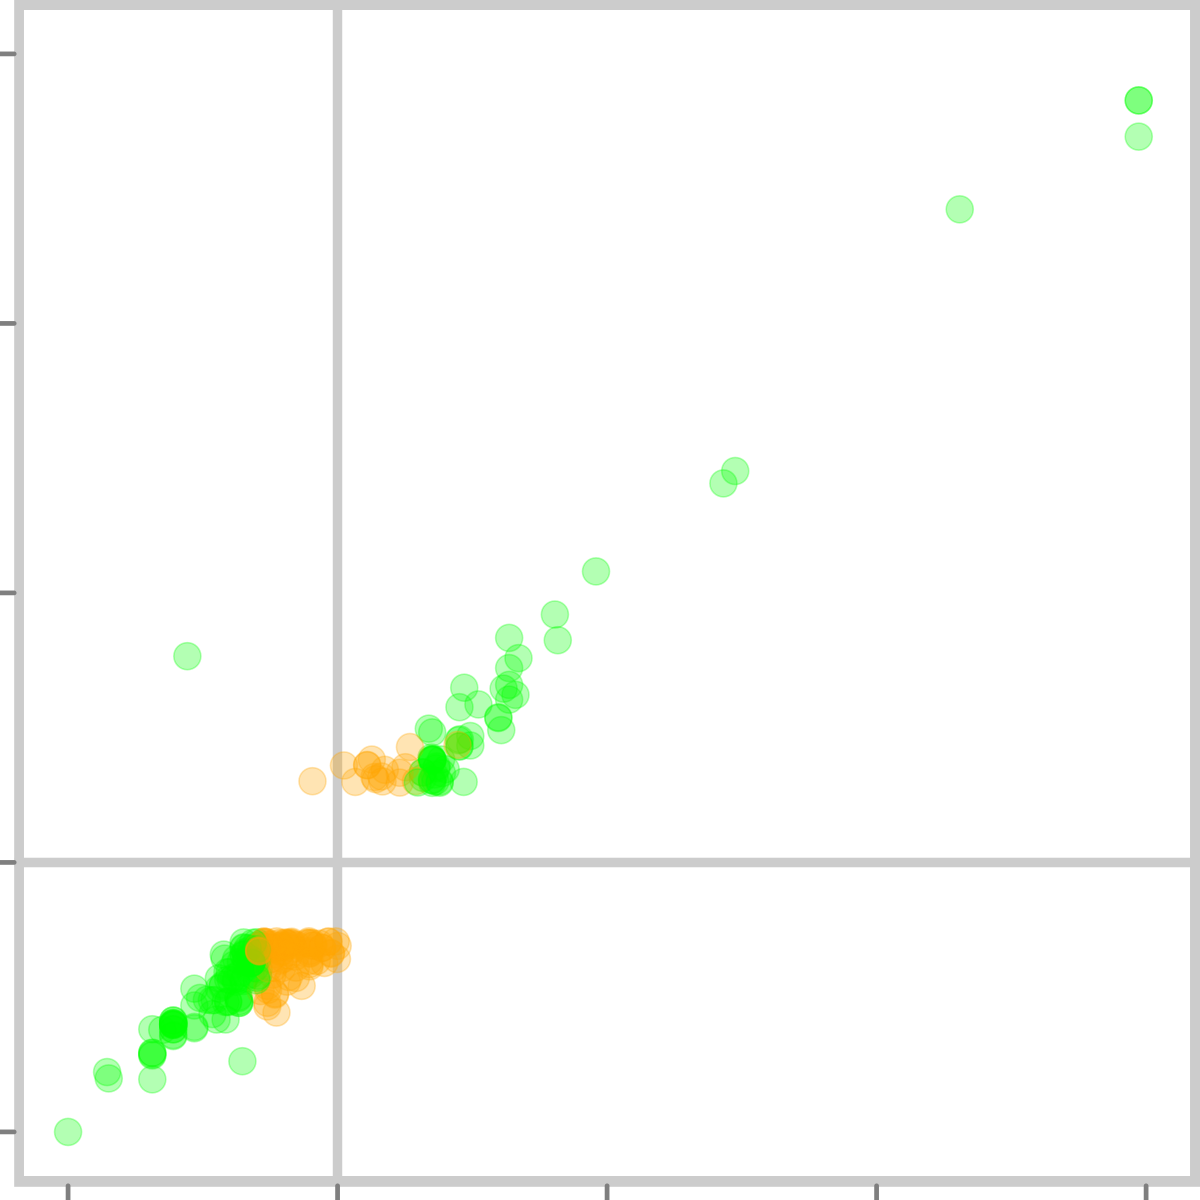

In [23]:
options(repr.plot.width = 10, repr.plot.height = 10)
library(ggrepel)

# Cap values for better visualization
DE_exons_with_gene_fc_capped <- DE_exons_MOL56 %>%
  mutate(
    log2FoldChange_exon = pmin(pmax(log2FoldChange_exon, -2), 6),
    log2FoldChange_gene = pmin(pmax(log2FoldChange_gene, -2), 6)
  )

ggplot(DE_exons_with_gene_fc_capped, aes(x = log2FoldChange_gene, y = log2FoldChange_exon, color = DE_status)) +
  geom_hline(yintercept = 0, color = "gray80", size = 2) +
  geom_vline(xintercept = 0, color = "gray80", size = 2) +
  
  geom_point(alpha = 0.3, size = 7) +  

  scale_color_manual(values = c("DE gene" = "green", "Non-DE gene" = "orange1")) +
  
  scale_x_continuous(limits = c(-2, 6), breaks = seq(-6, 6, by = 2),
                     labels = function(x) ifelse(x == -6, "≤-6", ifelse(x == 6, "≥6", x))) +
  scale_y_continuous(limits = c(-2, 6), breaks = seq(-6, 6, by = 2),
                     labels = function(y) ifelse(y == -6, "≤-6", ifelse(y == 6, "≥6", y))) +

  theme_void() +
  labs(
    x = "Gene log2FoldChange",
    y = "Exon log2FoldChange",
    color = "Gene Type"
  ) +

  theme(
    panel.border = element_rect(color = "gray80", fill = NA, size = 4),  
      axis.text.x = element_blank(),      
  axis.text.y = element_blank(),     
  axis.ticks.length = unit(0.3, "cm"), 
  axis.ticks = element_line(color = "gray50", size = 1), 
    legend.position = "none" 
  )



In [24]:
table(DE_exons_with_gene_fc_capped$DE_status)


    DE gene Non-DE gene 
        152         102 

## shared

In [ ]:
# shared DE genes

In [25]:
shared_genes <- base::intersect(DEG_2$gene_short_name, DEG_5$gene_short_name)
DEG_df_shared <- merge(DEG_2, DEG_5, by = "gene_short_name")
DEG_df_shared$source =  ifelse( DEG_df_shared$class.x == '25mo' &  DEG_df_shared$class.y == '25mo', 'up',
                               ifelse( DEG_df_shared$class.x == '2mo' &  DEG_df_shared$class.y == '2mo', 'down', 'mixed'))

In [26]:
dim(DEG_df_shared)

[1] 119  52

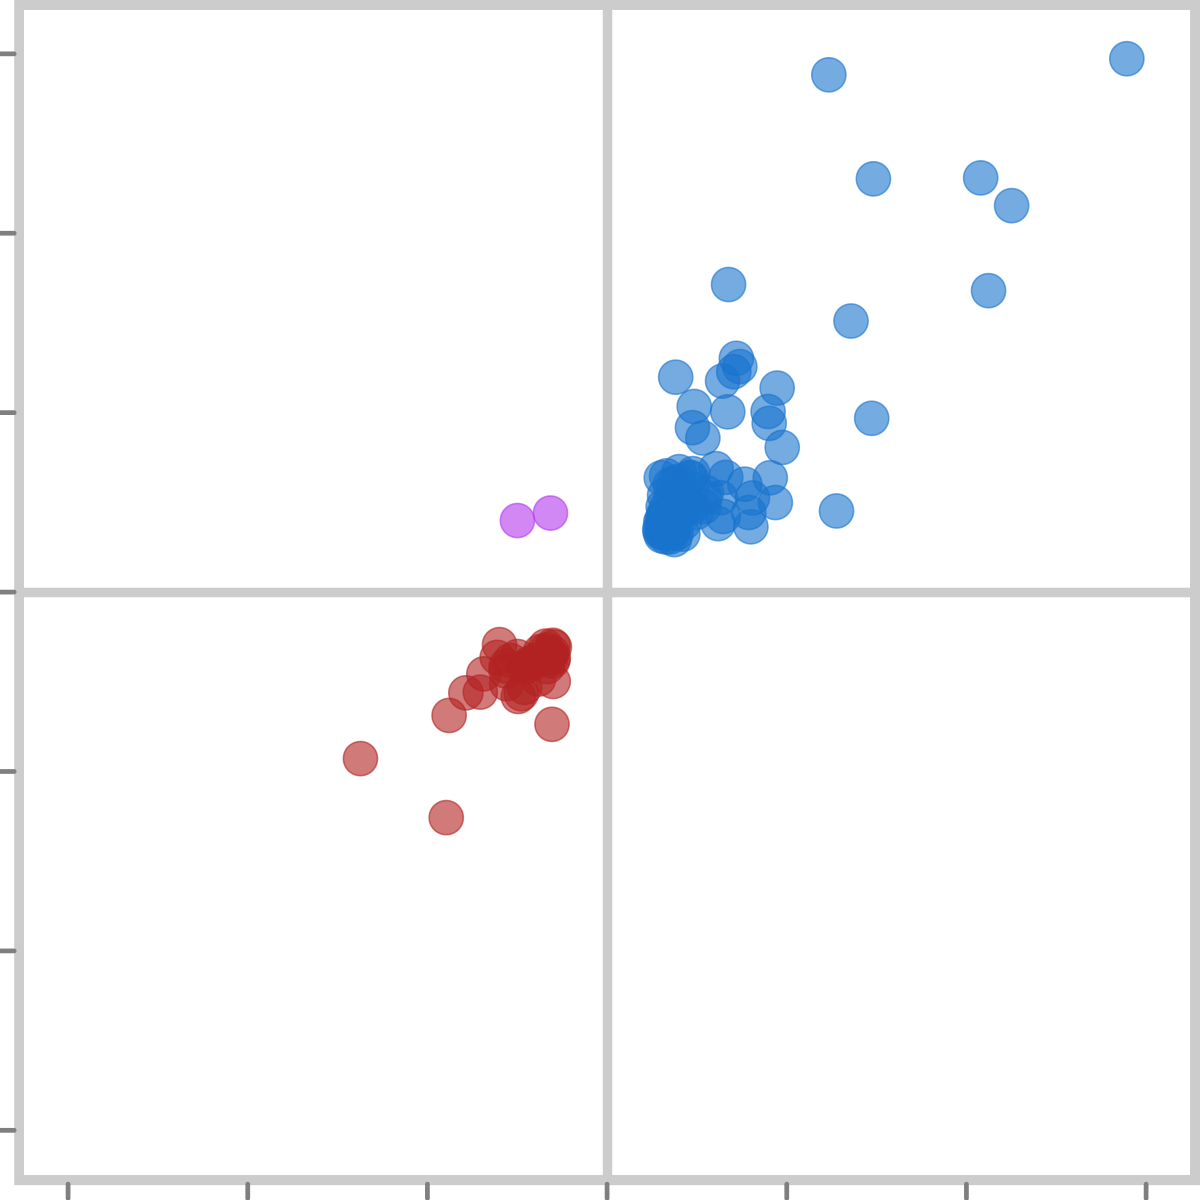

In [27]:
options(repr.plot.width = 10, repr.plot.height = 10)
library(ggrepel)

# Create a separate dataframe with capped values for plotting
DEG_df_shared_capped <- DEG_df_shared %>%
  mutate(
    log2FoldChange.x = pmin(pmax(log2FoldChange.x, -6), 6),
    log2FoldChange.y = pmin(pmax(log2FoldChange.y, -6), 6)
  )

ggplot(DEG_df_shared_capped, aes(x = log2FoldChange.x, y = log2FoldChange.y, color = source)) +
geom_hline(yintercept = 0, color = "gray80", size = 2) +
  geom_vline(xintercept = 0, color = "gray80", size = 2) +
  geom_point(alpha = 0.6, size = 9) +  
  scale_color_manual(values = c("up" = 'dodgerblue3', "down" = "firebrick", 'mixed' = 'darkorchid2')) +  # Custom colors

  scale_x_continuous(limits = c(-6, 6), breaks = seq(-6, 6, by = 2),
                     labels = function(x) ifelse(x == -6, "≤-6", ifelse(x == 6, "≥6", x))) +
  scale_y_continuous(limits = c(-6, 6), breaks = seq(-6, 6, by = 2),
                     labels = function(y) ifelse(y == -6, "≤-6", ifelse(y == 6, "≥6", y))) +

  theme_void() +
  labs(
    x = "log2FoldChange in MOL_2 (Aged vs. Young)",
    y = "log2FoldChange in MOL_5/6 (Aged vs. Young)",
    color = "DE OL Type"
  ) +

  theme(
    axis.text = element_text(size = 0, family = "Helvetica"), 
    panel.border = element_rect(color = "gray80", fill = NA, size = 4), 
      legend.position = 'none',  
  axis.ticks.length = unit(0.3, "cm"), 
  axis.ticks = element_line(color = "gray50", size = 1)     
  )
 

`geom_smooth()` using formula = 'y ~ x'


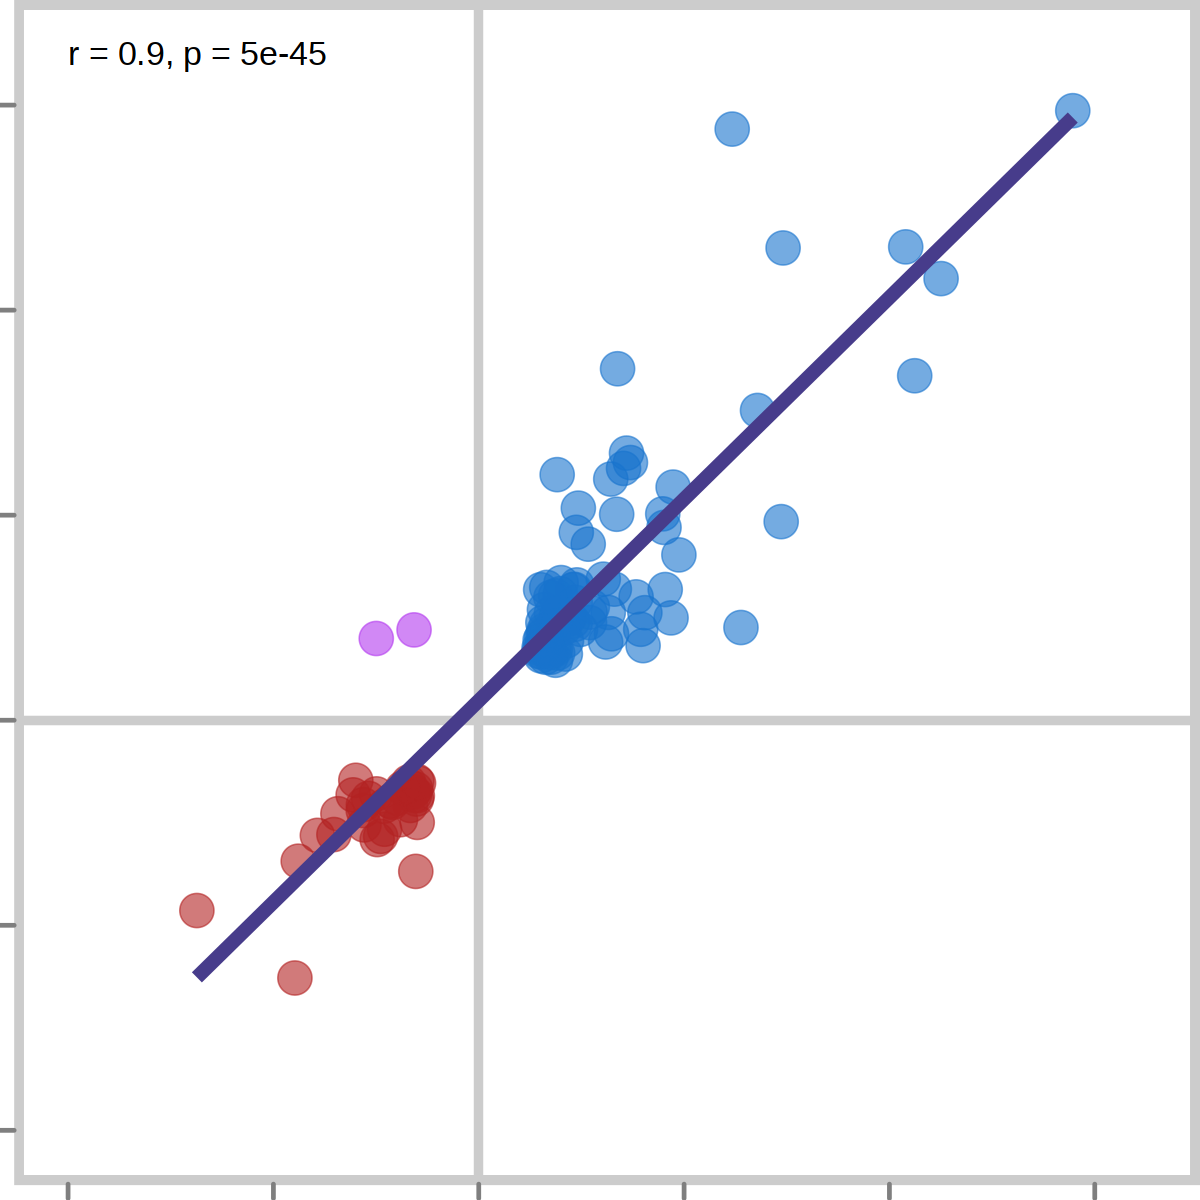

In [28]:
# Compute correlation
cor_result <- cor.test(DEG_df_shared_capped$log2FoldChange.x, DEG_df_shared_capped$log2FoldChange.y, method = "pearson")
r_val <- round(cor_result$estimate, 2)
p_val <- signif(cor_result$p.value, 2)

ggplot(DEG_df_shared_capped, aes(x = log2FoldChange.x, y = log2FoldChange.y, color = source)) +
  geom_hline(yintercept = 0, color = "gray80", size = 2) +
  geom_vline(xintercept = 0, color = "gray80", size = 2) +
  geom_point(alpha = 0.6, size = 9) +
  
  # Add correlation line
  geom_smooth(method = "lm", color = "slateblue4", se = FALSE, size = 3) +
  
  # Annotate r and p
  annotate("text", x = -4, y = 6.5, label = paste0("r = ", r_val, ", p = ", p_val),
           size = 7, color = "black", family = "Helvetica", hjust = 0) +

  scale_color_manual(values = c("up" = 'dodgerblue3', "down" = "firebrick", 'mixed' = 'darkorchid2')) +
  scale_x_continuous(limits = c(-4, 6.5), breaks = seq(-6, 6, by = 2),
                     labels = function(x) ifelse(x == -6, "≤-6", ifelse(x == 6, "≥6", x))) +
  scale_y_continuous(limits = c(-4, 6.5), breaks = seq(-6, 6, by = 2),
                     labels = function(y) ifelse(y == -6, "≤-6", ifelse(y == 6, "≥6", y))) +
  theme_void() +
  labs(
    x = "log2FoldChange in MOL_2 (Aged vs. Young)",
    y = "log2FoldChange in MOL_5/6 (Aged vs. Young)",
    color = "DE OL Type"
  ) +
  theme(
    axis.text = element_text(size = 0, family = "Helvetica"),
    panel.border = element_rect(color = "gray80", fill = NA, size = 4),
    legend.position = 'none',
    axis.ticks.length = unit(0.3, "cm"),
    axis.ticks = element_line(color = "gray50", size = 1)
  )


In [ ]:
# shared DE exons

In [29]:
dim(DE_exons_MOL56)
dim(DE_exons_MOL2)

[1] 254   7

[1] 261   7

In [30]:
# Merge the two dataframes on exon_id to compare the DE_status across cell types
merged_df <- full_join(DE_exons_MOL2, DE_exons_MOL56, by = "exon_id", suffix = c("_MOL2", "_MOL56"))

# Count the overlap categories
DE_gene_A_DE_gene_B <- sum(merged_df$DE_status_MOL2 == "DE gene" & merged_df$DE_status_MOL56 == "DE gene", na.rm = TRUE)
DE_gene_A_NonDE_gene_B <- sum(merged_df$DE_status_MOL2 == "DE gene" & merged_df$DE_status_MOL56 == "Non-DE gene", na.rm = TRUE)
NonDE_gene_A_DE_gene_B <- sum(merged_df$DE_status_MOL2 == "Non-DE gene" & merged_df$DE_status_MOL56 == "DE gene", na.rm = TRUE)
NonDE_gene_A_NonDE_gene_B <- sum(merged_df$DE_status_MOL2 == "Non-DE gene" & merged_df$DE_status_MOL56 == "Non-DE gene", na.rm = TRUE)

# Count unique exons in each cell type
unique_DE_gene_A <- sum(is.na(merged_df$DE_status_MOL56) & merged_df$DE_status_MOL2 == "DE gene")  # DE gene unique to MOL2
unique_NonDE_gene_A <- sum(is.na(merged_df$DE_status_MOL56) & merged_df$DE_status_MOL2 == "Non-DE gene")  # Non-DE gene unique to MOL2

unique_DE_gene_B <- sum(is.na(merged_df$DE_status_MOL2) & merged_df$DE_status_MOL56 == "DE gene")  # DE gene unique to MOL56
unique_NonDE_gene_B <- sum(is.na(merged_df$DE_status_MOL2) & merged_df$DE_status_MOL56 == "Non-DE gene")  # Non-DE gene unique to MOL56

# Create the final table with proper column names
overlap_table <- data.frame(
  "all MOL DE exons" = c("DE gene (MOL2)", "Non-DE gene (MOL2)", "Unique to MOL5/6"),
  "  DE gene (MOL5/6)" = c(DE_gene_A_DE_gene_B, NonDE_gene_A_DE_gene_B, unique_DE_gene_B),
  "  Non-DE gene (MOL5/6)" = c(DE_gene_A_NonDE_gene_B, NonDE_gene_A_NonDE_gene_B, unique_NonDE_gene_B),
  "  Unique to MOL2" = c(unique_DE_gene_A, unique_NonDE_gene_A, "--"),
  check.names = FALSE  # Prevents R from replacing spaces with dots
)

# Print the table
print(overlap_table, row.names = FALSE)


   all MOL DE exons   DE gene (MOL5/6)   Non-DE gene (MOL5/6)   Unique to MOL2
     DE gene (MOL2)                 56                      8               86
 Non-DE gene (MOL2)                  8                     31               72
   Unique to MOL5/6                 88                     63               --


In [31]:
merged_df$overlap_category <- ifelse(is.na(merged_df$DE_status_MOL2) & !is.na(merged_df$DE_status_MOL56) & merged_df$DE_status_MOL56 == 'DE gene', 
                                     "DE gene & DE exon only in MOL5/6", 
                              ifelse(is.na(merged_df$DE_status_MOL2) & !is.na(merged_df$DE_status_MOL56) & merged_df$DE_status_MOL56 == 'Non-DE gene', 
                                     "Non-DE gene & DE exon only in MOL5/6", 
                              ifelse(is.na(merged_df$DE_status_MOL56) & !is.na(merged_df$DE_status_MOL2) & merged_df$DE_status_MOL2 == 'DE gene', 
                                     "DE gene & DE exon only in MOL2", 
                              ifelse(is.na(merged_df$DE_status_MOL56) & !is.na(merged_df$DE_status_MOL2) & merged_df$DE_status_MOL2 == 'Non-DE gene', 
                                    "Non-DE gene & DE exon only in MOL2", 
                              ifelse(merged_df$DE_status_MOL2 == "DE gene" & merged_df$DE_status_MOL56 == "DE gene", 
                                    "DE gene, DE exon in both",
                              ifelse(merged_df$DE_status_MOL2 == "DE gene" & merged_df$DE_status_MOL56 == "Non-DE gene", 
                                    "DE gene in MOL2, Non-DE gene in MOL5/6",
                              ifelse(merged_df$DE_status_MOL2 == "Non-DE gene" & merged_df$DE_status_MOL56 == "DE gene", 
                                    "DE gene in MOL5/6, Non-DE gene in MOL2",
                              ifelse(merged_df$DE_status_MOL2 == "Non-DE gene" & merged_df$DE_status_MOL56 == "Non-DE gene", 
                                    'Non-DE gene, DE exon in both', 
                                                                        "NONE"))))))))

merged_df_fixNA = merged_df

# Merge DEG_df2 with merged_df_fixNA to get the corresponding log2FoldChange values for MOL2 non-DE exons
merged_with_DE2 <- merged_df_fixNA[is.na(merged_df_fixNA$log2FoldChange_exon_MOL2),] %>%
  left_join(df_de_mol2[, c("exon_id", "log2FoldChange")], by = "exon_id")
# Replace NA values in log2FoldChange_exon_MOL2 with the values from DEG_df2
merged_df_fixNA[is.na(merged_df_fixNA$log2FoldChange_exon_MOL2), ]$log2FoldChange_exon_MOL2 <- merged_with_DE2$log2FoldChange

# Merge DEG_df56 with merged_df_fixNA to get the corresponding log2FoldChange values for MOL56 non-DE exons
merged_with_DE56 <- merged_df_fixNA[is.na(merged_df_fixNA$log2FoldChange_exon_MOL56),] %>%
  left_join(df_de_mol56[, c("exon_id", "log2FoldChange")], by = "exon_id")
# Replace NA values in log2FoldChange_exon_MOL56 with the values from DEG_df56
merged_df_fixNA[is.na(merged_df_fixNA$log2FoldChange_exon_MOL56),]$log2FoldChange_exon_MOL56 <- merged_with_DE56$log2FoldChange


merged_df_capped <- merged_df_fixNA %>%
  mutate(
    log2FoldChange_exon_MOL2 = pmin(pmax(log2FoldChange_exon_MOL2, -8), 6),
    log2FoldChange_exon_MOL56 = pmin(pmax(log2FoldChange_exon_MOL56, -8), 6)
  )

merged_df_capped$unique_or_shared = ifelse(merged_df_capped$overlap_category == "DE gene & DE exon only in MOL5/6" | merged_df_capped$overlap_category == "Non-DE gene & DE exon only in MOL5/6" | 
            merged_df_capped$overlap_category == "DE gene & DE exon only in MOL2" | merged_df_capped$overlap_category == "Non-DE gene & DE exon only in MOL2" , 'unique', 'shared')                               

In [32]:
table(merged_df[merged_df_capped$unique_or_shared == 'shared',]$overlap_category)


DE gene in MOL2, Non-DE gene in MOL5/6 DE gene in MOL5/6, Non-DE gene in MOL2 
                                     8                                      8 
              DE gene, DE exon in both           Non-DE gene, DE exon in both 
                                    56                                     31 

In [33]:
dim(merged_df_capped[merged_df_capped$unique_or_shared == 'unique',])
dim(merged_df_capped[merged_df_capped$unique_or_shared == 'shared',])
dim(merged_df_capped)

[1] 309  15

[1] 103  15

[1] 412  15

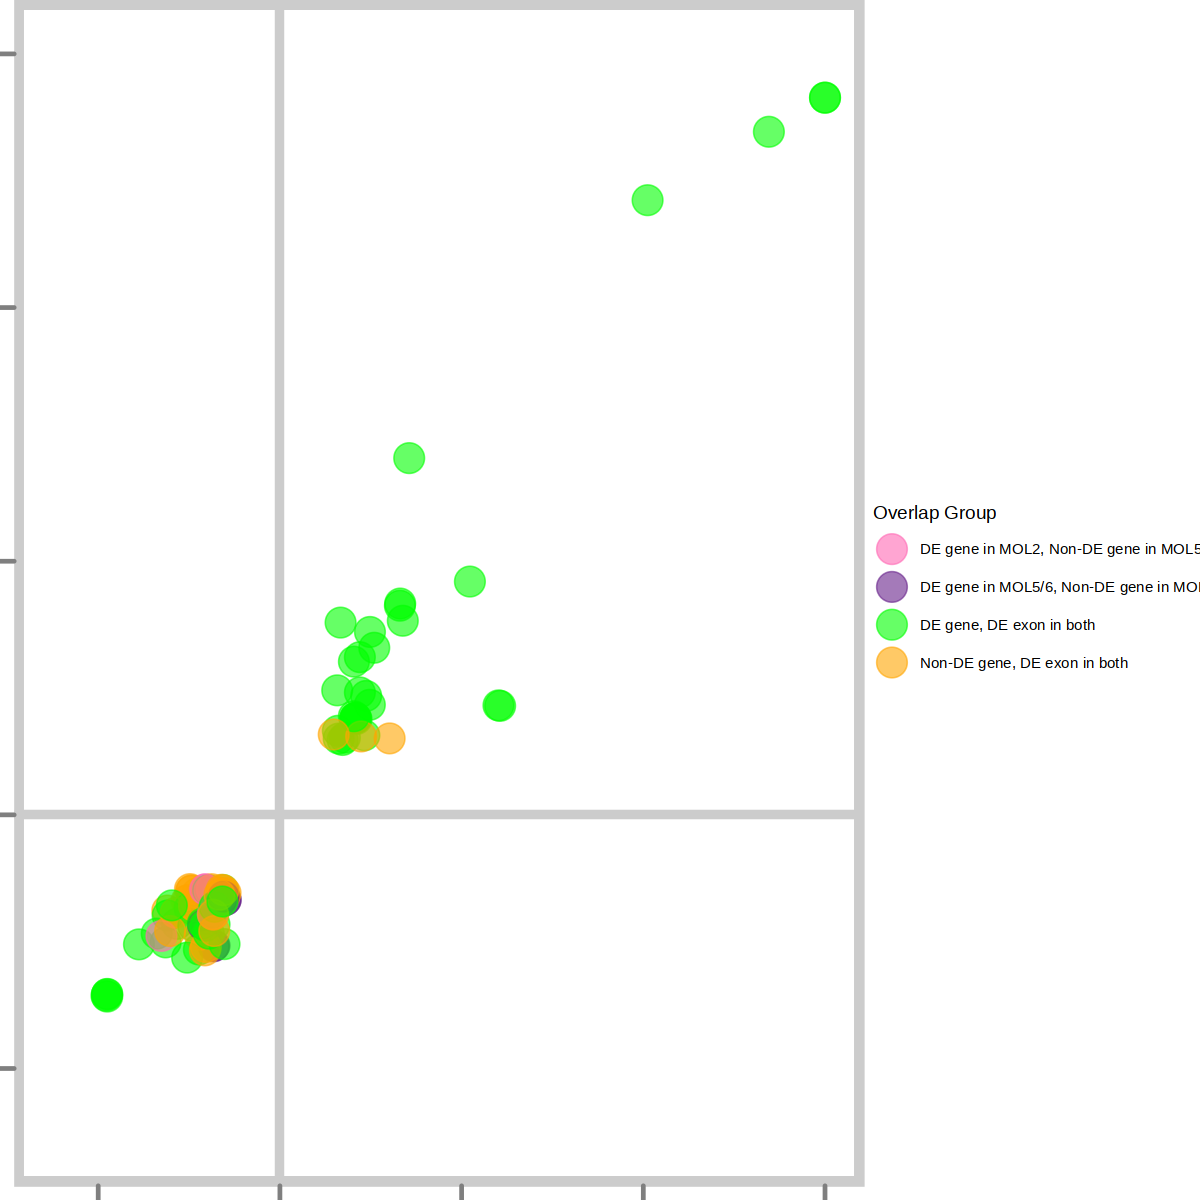

In [34]:
options(repr.plot.width = 10, repr.plot.height = 10)                                      
ggplot(merged_df_capped[merged_df_capped$unique_or_shared == 'shared',], aes(x = log2FoldChange_exon_MOL2, y = log2FoldChange_exon_MOL56, color = overlap_category)) +
geom_hline(yintercept = 0, color = "gray80", size = 2) +
  geom_vline(xintercept = 0, color = "gray80", size = 2) +
  geom_point(alpha = 0.6, size = 8) + 
   scale_color_manual(values = c("DE gene in MOL2, Non-DE gene in MOL5/6" = 'hotpink', 
                                 "DE gene in MOL5/6, Non-DE gene in MOL2" = "darkorchid4", 
                                 'DE gene, DE exon in both' = 'green',
                                'Non-DE gene, DE exon in both' = 'orange1'
                                 )) + 

  scale_x_continuous(limits = c(-2.5, 6), breaks = seq(-8, 8, by = 2),
                     labels = function(x) ifelse(x == -8, "≤-8", ifelse(x == 8, "≥8", x))) +
  scale_y_continuous(limits = c(-2.5, 6), breaks = seq(-8, 8, by = 2),
                     labels = function(y) ifelse(y == -8, "≤-8", ifelse(y == 8, "≥8", y))) +

  theme_void() +
  labs(
#    x = "log2FoldChange in MOL_2 (Aged vs. Young)",
#    y = "log2FoldChange in MOL_5/6 (Aged vs. Young)",
    color = "Overlap Group"
  ) +

  theme(
    panel.border = element_rect(color = "gray80", fill = NA, size = 4),
      axis.text.x = element_blank(),     
  axis.text.y = element_blank(),     
  axis.ticks.length = unit(0.3, "cm"),
  axis.ticks = element_line(color = "gray50", size = 1),
    legend.position = "right" 
  )
 

`geom_smooth()` using formula = 'y ~ x'


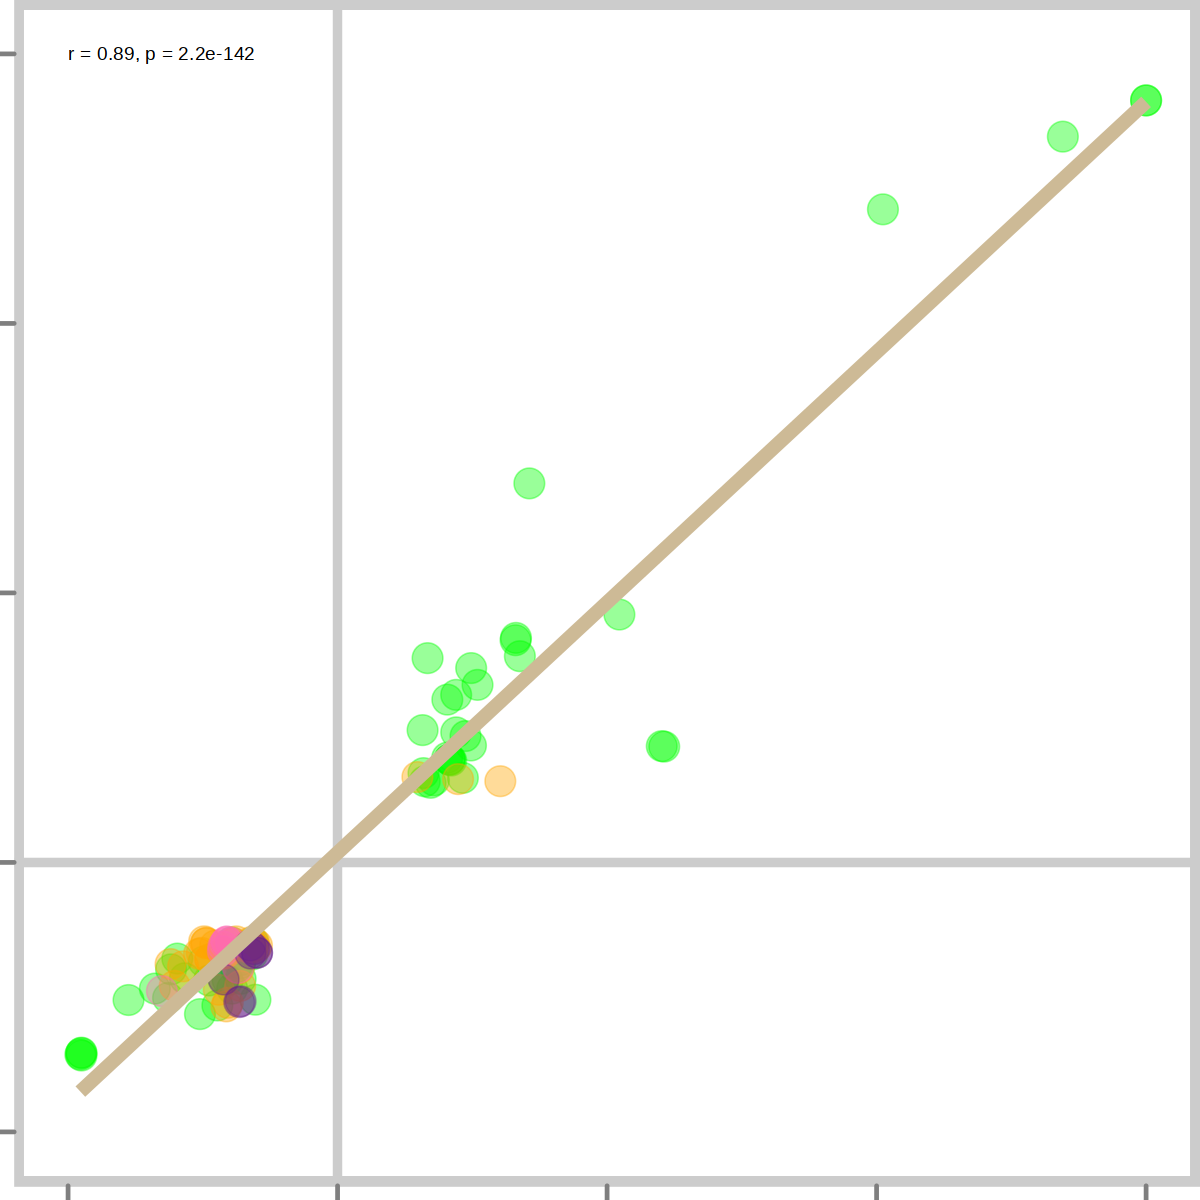

In [35]:
options(repr.plot.width = 10, repr.plot.height = 10)

cor_result <- cor.test(merged_df_capped$log2FoldChange_exon_MOL2, merged_df_capped$log2FoldChange_exon_MOL56, method = "pearson")

# Extract values
r_val <- round(cor_result$estimate, 2)
p_val <- signif(cor_result$p.value, 2)

merged_df_capped <- merged_df_capped %>%
  mutate(overlap_category = factor(overlap_category, levels = c(
    # less important categories first
    "DE gene, DE exon in both",
     "Non-DE gene, DE exon in both",
      "DE gene in MOL2, Non-DE gene in MOL5/6",
    "DE gene in MOL5/6, Non-DE gene in MOL2"
    
      # most important category last
  ))) %>%
  arrange(overlap_category)

ggplot(merged_df_capped[merged_df_capped$unique_or_shared == 'shared',], aes(x = log2FoldChange_exon_MOL2, y = log2FoldChange_exon_MOL56, color = overlap_category)) +
geom_hline(yintercept = 0, color = "gray80", size = 2) +
  geom_vline(xintercept = 0, color = "gray80", size = 2) +
  geom_point(alpha = 0.4, size = 8) +  # Use color mapping for DE status

  # Add correlation line
  geom_smooth(method = "lm", color = "wheat3", se = FALSE, size = 3) +
  
  # Annotate r and p
  annotate("text", x = -2, y = 6, label = paste0("r = ", r_val, ", p = ", p_val),
           size = 4, color = "black", family = "Helvetica", hjust = 0) +


   scale_color_manual(values = c("DE gene in MOL2, Non-DE gene in MOL5/6" = 'hotpink', 
                                 "DE gene in MOL5/6, Non-DE gene in MOL2" = "darkorchid4", 
                                 'DE gene, DE exon in both' = 'green',
                                'Non-DE gene, DE exon in both' = 'orange1'
                                 )) +  # Custom colors "darkorchid4", "Non-DE gene" = "hotpink"

  # Add gray x and y axes at (0,0)
  
  
  # Set manual axis limits and breaks at intervals of 2
  scale_x_continuous(limits = c(-2, 6), breaks = seq(-8, 8, by = 2),
                     labels = function(x) ifelse(x == -8, "≤-8", ifelse(x == 8, "≥8", x))) +
  scale_y_continuous(limits = c(-2, 6), breaks = seq(-8, 8, by = 2),
                     labels = function(y) ifelse(y == -8, "≤-8", ifelse(y == 8, "≥8", y))) +

  theme_void() +
  labs(
    x = "log2FoldChange in MOL_2 (Aged vs. Young)",
    y = "log2FoldChange in MOL_5/6 (Aged vs. Young)",
    color = "Overlap Group"#,
    #title = "Volcano Plot: Gene Foldchange vs Exon Foldchange for DE Exons"
  ) +

  theme(
       # axis.text = element_text(size = 29, family = "Helvetica"),  # Adjust axis text size
    panel.border = element_rect(color = "gray80", fill = NA, size = 4),  # Gray panel border
      axis.text.x = element_blank(),       # remove axis numbers
  axis.text.y = element_blank(),       # remove axis numbers
  axis.ticks.length = unit(0.3, "cm"), # set tick length
  axis.ticks = element_line(color = "gray50", size = 1), # show tick lines

    legend.position = "none"  # Hide legend
  )
 

In [238]:
cds_brain$Main_cluster_name = df_test$Main_cluster_name
cds_brain$umap_1 = df_test$umap_1
cds_brain$umap_2 = df_test$umap_2

In [178]:
#gene_list = c('Ly6c1','Rgs5','Flt1','Dipk2b','Adgrl4' )#, 'Lgr6', 'Trdn','Gng4','Lgr5','Meis2')
gene_list = c('Cyp2j12','Mag','Tnni1','Galnt6','Opalin' )
#gene_list = c('Vipr2','Cpa6','Tshz1','Adamts19','Pbx3')
gene_id_list = fData(cds_brain)$gene_id[fData(cds_brain)$gene_short_name %in% gene_list]

In [179]:
plot_gene_module <- function (cds, gene_list, coord_x, coord_y, label_name = "log10(values + 0.1)", 
    cell_size = 1, top_v = 3, low_v = -3) 
{
    cds_sampled = cds[as.character(gene_list), ]
    gene_sampled = log10(normal_expr(cds_sampled) + 0.1)
    gene_agg_expr = Matrix::colSums(gene_sampled)
    gene_agg_expr = scale(gene_agg_expr)
    gene_agg_expr[gene_agg_expr > top_v] = top_v
    gene_agg_expr[gene_agg_expr < low_v] = low_v
    cds$tmp = gene_agg_expr
    g1 = (ggplot(data = pData(cds), aes(x = coord_x, y = coord_y, 
            color = (tmp), alpha = tmp + 1)) + ggrastr::geom_point_rast(size = cell_size, 
            stroke = 0, shape = 16, na.rm = T) + theme_void() + 
            scale_color_continuous(name = 'module',low = "grey70", 
                high = "firebrick", position = "top") + scale_alpha_continuous(range = c(0.1, 
            1), guide = "none") + guides(alpha = F) + theme(legend.title = element_text(size = 6), 
            legend.text = element_text(size = 6), legend.margin = margin(0, 
                -10, 0, 10), legend.key.width = unit(0.15, "in"), 
            legend.key.height = unit(0.15, "in"), legend.position = "left"))
        pData(cds)$tmp = NULL
        return(g1)
}

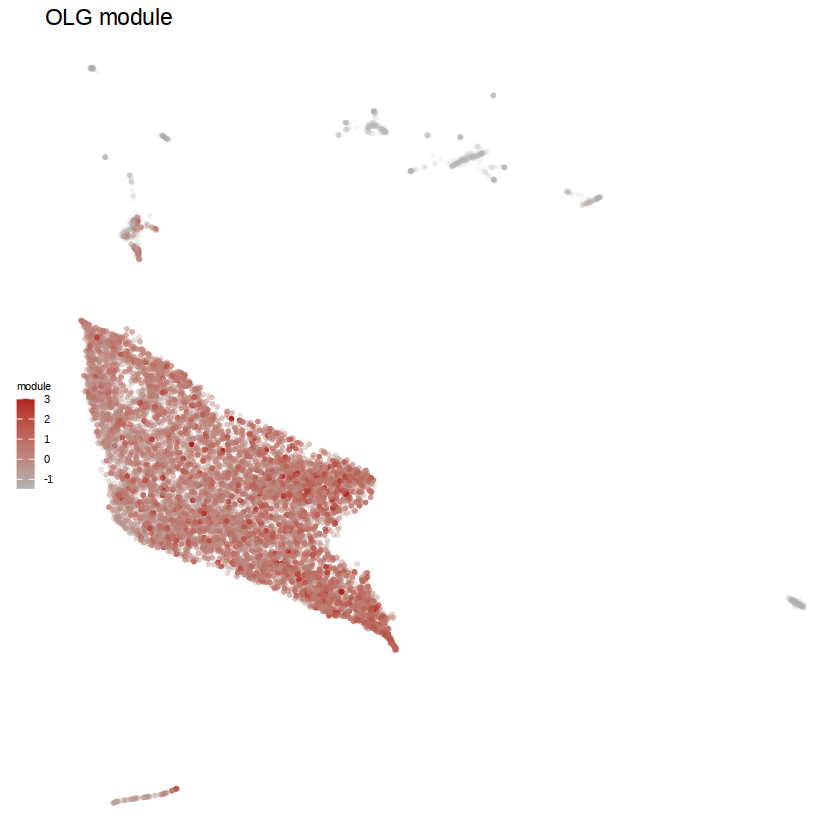

In [181]:
# OLG module genes
b1 = plot_gene_module(cds_brain, gene_id_list, cds_brain$umap_1, cds_brain$umap_2, cell_size = 1.5)
b1 + ggtitle("OLG module")

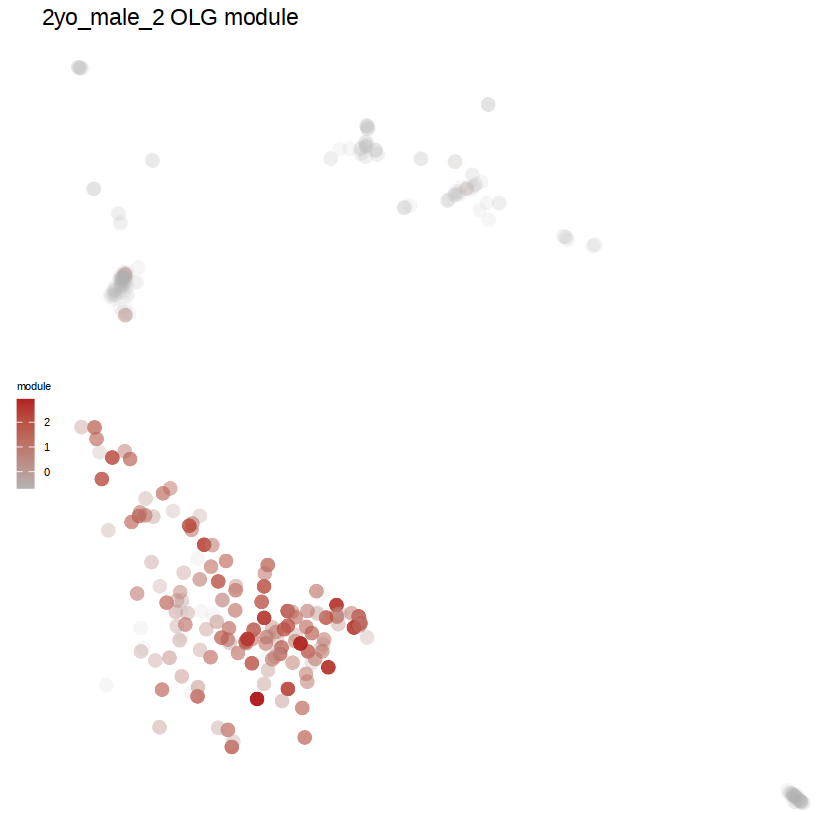

In [187]:
# OLG module genes
b1 = plot_gene_module(cds_brain[ ,pData(cds_brain)$Conditions == '2yo_male_2'], gene_id_list, cds_brain[, pData(cds_brain)$Conditions == '2yo_male_2']$umap_1, cds_brain[, pData(cds_brain)$Conditions == '2yo_male_2']$umap_2, cell_size = 4)
b1 + ggtitle("2yo_male_2 OLG module")

In [271]:
plot_UMI_count <- function (cds, coord_x = "umap_1", coord_y = "umap_2", 
                            label_name = "log10(UMI_count + 0.1)", cell_size = 1, 
                            top_v = 5, low_v = 0) 
{
    # Check if UMI_count exists in pData
    if (!"UMI_count" %in% colnames(pData(cds))) {
        stop("UMI_count not found in pData(cds). Please ensure UMI_count is available in pData.")
    }
    
    # Log-transform the UMI_count values
    umi_count_log <- log10(pData(cds)$UMI_count + 0.1)
    
    # Clip values to specified range
    umi_count_log[umi_count_log > top_v] <- top_v
    umi_count_log[umi_count_log < low_v] <- low_v
    
    # Add transformed UMI_count to the cds object
    pData(cds)$tmp <- umi_count_log
    
    # Generate the plot
    g1 <- ggplot(data = pData(cds), aes_string(x = coord_x, y = coord_y, 
                                               color = "tmp", alpha = "tmp + 1")) + 
          ggrastr::geom_point_rast(size = cell_size, stroke = 0, shape = 16, na.rm = TRUE) + 
          theme_void() + 
          scale_color_continuous(name = 'log10(UMI_count + 0.1)', low = "grey70", high = "firebrick", 
                                 limits = c(low_v, top_v), position = "top") + 
          scale_alpha_continuous(range = c(0.1, 1), guide = "none") + 
          guides(alpha = FALSE) + 
          theme(legend.title = element_text(size = 6), 
                legend.text = element_text(size = 6), 
                legend.margin = margin(0, -10, 0, 10), 
                legend.key.width = unit(0.15, "in"), 
                legend.key.height = unit(0.15, "in"), 
                legend.position = "left")
    
    # Clean up temporary data
    pData(cds)$tmp <- NULL
    
    return(g1)
}

In [284]:
plot_UMI_count <- function (cds, coord_x = "umap_1", coord_y = "umap_2", 
                            label_name = "log10(UMI_count)", cell_size = 1, 
                            top_percentile = 0.95, low_percentile = 0) 
{
    # Check if UMI_count exists in pData
    if (!"UMI_count" %in% colnames(pData(cds))) {
        stop("UMI_count not found in pData(cds). Please ensure UMI_count is available in pData.")
    }
    
    # Log-transform the UMI_count values
    umi_count_log <- log10(pData(cds)$UMI_count)
    
    # Determine top_v and low_v based on specified percentiles
    top_v <- quantile(umi_count_log, top_percentile)
    low_v <- quantile(umi_count_log, low_percentile)
    
    # Clip values to specified range
    umi_count_log[umi_count_log > top_v] <- top_v
    umi_count_log[umi_count_log < low_v] <- low_v
    
    # Add log-transformed UMI_count to the cds object temporarily
    pData(cds)$tmp <- umi_count_log
    
    # Generate the plot
    g1 <- ggplot(data = pData(cds), aes_string(x = coord_x, y = coord_y, 
                                               color = "tmp", alpha = "tmp + 1")) + 
          ggrastr::geom_point_rast(size = cell_size, stroke = 0, shape = 16, na.rm = TRUE) + 
          theme_void() + 
          scale_color_viridis_c(name = label_name, option = "plasma", 
                                limits = c(low_v, top_v), begin = 0, end = 1) + 
          scale_alpha_continuous(range = c(0.1, 1), guide = "none") + 
          guides(alpha = FALSE) + 
          theme(legend.title = element_text(size = 6), 
                legend.text = element_text(size = 6), 
                legend.margin = margin(0, -10, 0, 10), 
                legend.key.width = unit(0.15, "in"), 
                legend.key.height = unit(0.15, "in"), 
                legend.position = "left")
    
    # Clean up temporary data
    pData(cds)$tmp <- NULL
    
    return(g1)
}

In [188]:
plot_UMI_count <- function (cds, coord_x = "umap_1", coord_y = "umap_2", 
                            label_name = "log10(UMI_count)", cell_size = 1, 
                            top_v = 4, low_v = 0) 
{
    # Check if UMI_count exists in pData
    if (!"UMI_count" %in% colnames(pData(cds))) {
        stop("UMI_count not found in pData(cds). Please ensure UMI_count is available in pData.")
    }
    
    # Log-transform the UMI_count values
    umi_count_log <- log10(pData(cds)$UMI_count)
    
    # Clip values to specified range
    umi_count_log[umi_count_log > top_v] <- top_v
    umi_count_log[umi_count_log < low_v] <- low_v
    
    # Add log-transformed UMI_count to the cds object temporarily
    pData(cds)$tmp <- umi_count_log
    
    # Generate the plot
    g1 <- ggplot(data = pData(cds), aes_string(x = coord_x, y = coord_y, 
                                               color = "tmp", alpha = "tmp + 1")) + 
          ggrastr::geom_point_rast(size = cell_size, stroke = 0, shape = 16, na.rm = TRUE) + 
          theme_void() + 
          scale_color_viridis_c(name = label_name, option = "plasma", 
                                limits = c(low_v, top_v), begin = 0, end = 1) + 
          scale_alpha_continuous(range = c(0.1, 1), guide = "none") + 
          guides(alpha = FALSE) + 
          theme(legend.title = element_text(size = 6), 
                legend.text = element_text(size = 6), 
                legend.margin = margin(0, -10, 0, 10), 
                legend.key.width = unit(0.15, "in"), 
                legend.key.height = unit(0.15, "in"), 
                legend.position = "left")
    
    # Clean up temporary data
    pData(cds)$tmp <- NULL
    
    return(g1)
}

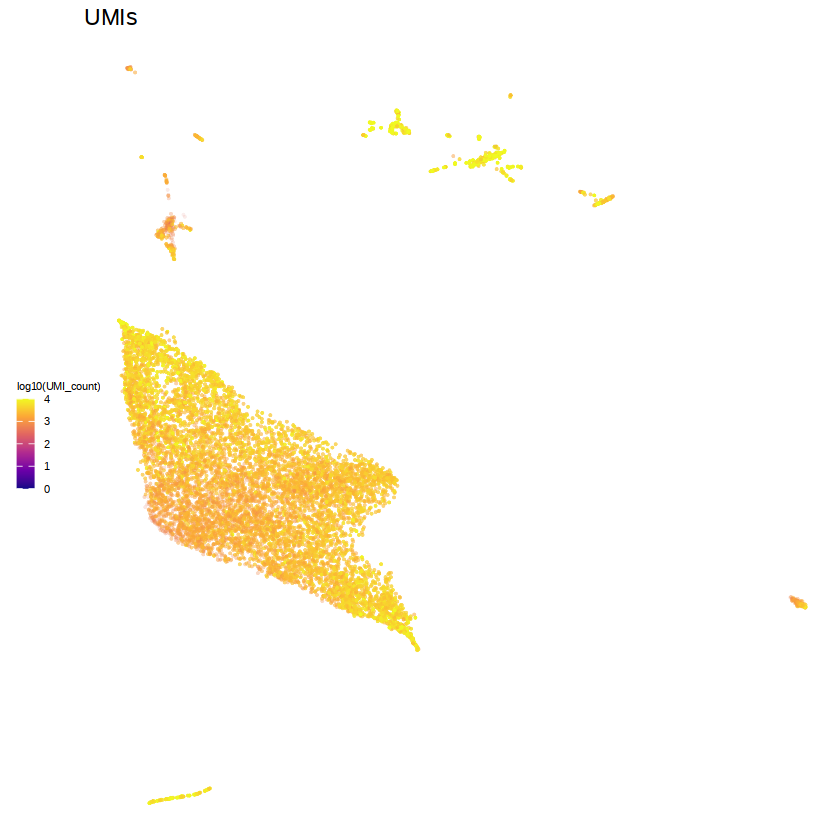

In [191]:
b1 = plot_UMI_count(cds_brain, cds_brain$umap_1, cds_brain$umap_2, cell_size = 1)
b1 + ggtitle("UMIs")

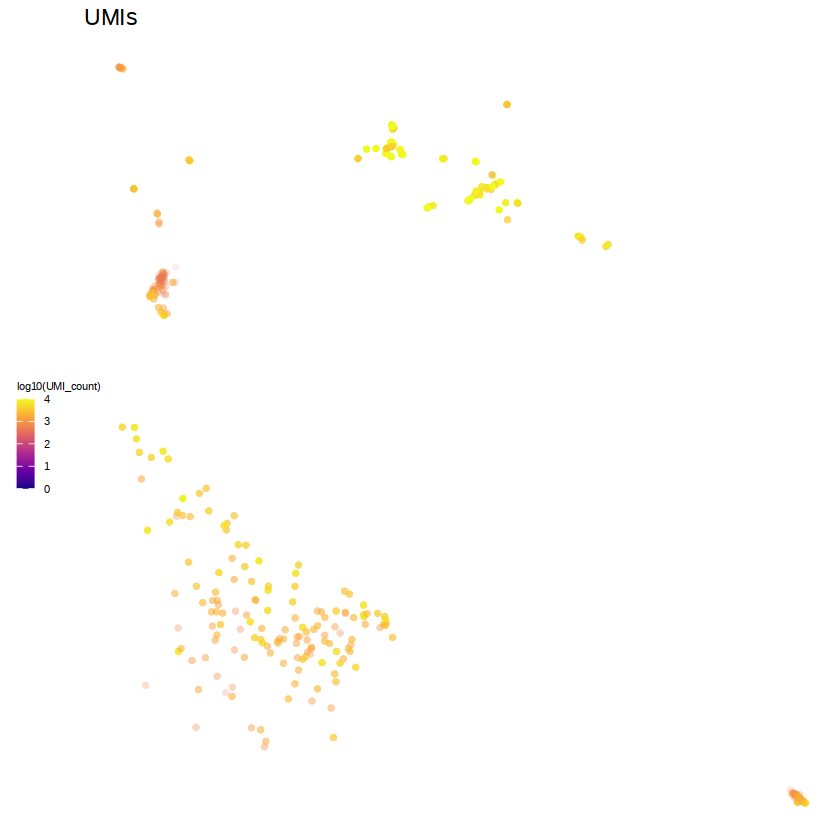

In [192]:
b1 = plot_UMI_count(cds_brain[,pData(cds_brain)$Conditions == '2yo_male_2'], cds_brain[,pData(cds_brain)$Conditions == '2yo_male_2']$umap_1, cds_brain[,pData(cds_brain)$Conditions == '2yo_male_2']$umap_2, cell_size = 2)
b1 + ggtitle("UMIs")

In [238]:
cds_brain$Main_cluster_name = df_test$Main_cluster_name
cds_brain$umap_1 = df_test$umap_1
cds_brain$umap_2 = df_test$umap_2

In [544]:
#gene_list = c('Ly6c1','Rgs5','Flt1','Dipk2b','Adgrl4' )#, 'Lgr6', 'Trdn','Gng4','Lgr5','Meis2')
#gene_list = c('Cyp2j12','Mag','Tnni1','Galnt6','Opalin' )
gene_list = c('Vipr2','Cpa6','Tshz1','Adamts19','Pbx3')
gene_id_list = fData(cds_brain)$gene_id[fData(cds_brain)$gene_short_name %in% gene_list]

In [241]:
plot_gene_module <- function (cds, gene_list, coord_x, coord_y, label_name = "log10(values + 0.1)", 
    cell_size = 1, top_v = 3, low_v = -3) 
{
    cds_sampled = cds[as.character(gene_list), ]
    gene_sampled = log10(normal_expr(cds_sampled) + 0.1)
    gene_agg_expr = Matrix::colSums(gene_sampled)
    gene_agg_expr = scale(gene_agg_expr)
    gene_agg_expr[gene_agg_expr > top_v] = top_v
    gene_agg_expr[gene_agg_expr < low_v] = low_v
    cds$tmp = gene_agg_expr
    g1 = (ggplot(data = pData(cds), aes(x = coord_x, y = coord_y, 
            color = (tmp), alpha = tmp + 1)) + ggrastr::geom_point_rast(size = cell_size, 
            stroke = 0, shape = 16, na.rm = T) + theme_void() + 
            scale_color_continuous(name = 'module',low = "grey70", 
                high = "firebrick", position = "top") + scale_alpha_continuous(range = c(0.1, 
            1), guide = "none") + guides(alpha = F) + theme(legend.title = element_text(size = 6), 
            legend.text = element_text(size = 6), legend.margin = margin(0, 
                -10, 0, 10), legend.key.width = unit(0.15, "in"), 
            legend.key.height = unit(0.15, "in"), legend.position = "left"))
        pData(cds)$tmp = NULL
        return(g1)
}

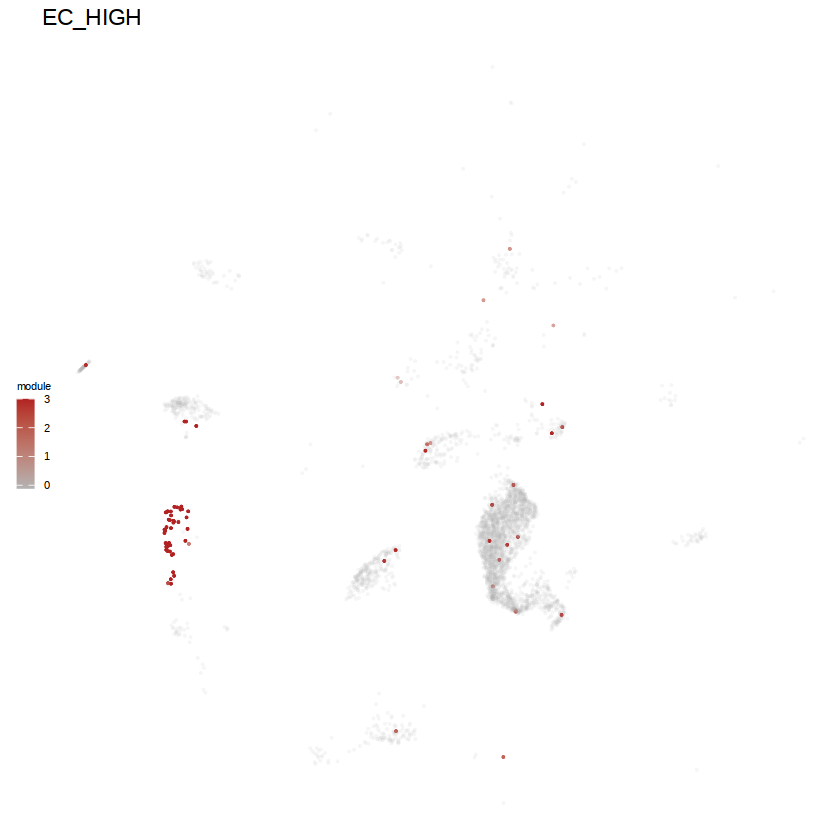

In [539]:
# EC module genes
b1 = plot_gene_module(cds_brain[ ,pData(cds_brain)$Conditions == 'EC_HIGH'], gene_id_list, cds_brain[, pData(cds_brain)$Conditions == 'EC_HIGH']$umap_1, cds_brain[, pData(cds_brain)$Conditions == 'EC_HIGH']$umap_2, cell_size = 1)
b1 + ggtitle("EC_HIGH")